Data can be downloaded from https://www.kaggle.com/datasets/nipunarora8/age-gender-and-ethnicity-face-data-csv?datasetId=855240&sortBy=voteCount \
Or use the cell bellow



In [ ]:
!pip install --upgrade --no-cache-dir gdown
!gdown https://drive.google.com/uc?id=1RtaD_uBD0xrNI1qHKakkgchQWekz9RyP

In [ ]:
!unzip archive.zip

In [ ]:
%%capture
!pip install livelossplot
!pip install tensorflow_addons

# Imports

In [2]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import precision_score, recall_score, f1_score, r2_score
from sklearn.metrics import classification_report
from sklearn.metrics import mean_absolute_error

import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras.layers import Input, Dense, Conv2D
from tensorflow.keras.layers import Dropout, MaxPooling2D, Flatten
from tensorflow.keras.utils import plot_model
from livelossplot.tf_keras import PlotLossesCallback



# Reading and data preparation

In [3]:
IMAGE_SIZE = (48, 48)
CHECKPOINT_PATH = './checkpoints/'
!mkdir {CHECKPOINT_PATH}

mkdir: cannot create directory ‘./checkpoints/’: File exists


In [4]:
data = pd.read_csv('./age_gender.csv')

In [5]:
print(data.shape)
data.head()

(23705, 5)


,age,ethnicity,gender,img_name,pixels
0,1,2,0,20161219203650636.jpg.chip.jpg,129 128 128 126 127 130 133 135 139 142 145 14...
1,1,2,0,20161219222752047.jpg.chip.jpg,164 74 111 168 169 171 175 182 184 188 193 199...
2,1,2,0,20161219222832191.jpg.chip.jpg,67 70 71 70 69 67 70 79 90 103 116 132 145 155...
3,1,2,0,20161220144911423.jpg.chip.jpg,193 197 198 200 199 200 202 203 204 205 208 21...
4,1,2,0,20161220144914327.jpg.chip.jpg,202 205 209 210 209 209 210 211 212 214 218 21...


In [6]:
# Check missing data
data.isnull().sum()

age          0
ethnicity    0
gender       0
img_name     0
pixels       0
dtype: int64

Let's convert pixel values from string format to numpy array. And apply reshape.

In [7]:
data.pixels = data.pixels.apply(lambda pix: np.fromstring(pix, dtype=int, sep=' ').reshape(*IMAGE_SIZE, 1)) / 255.

## Data distribution

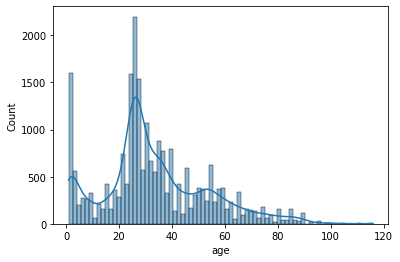

In [8]:
# Age distribution
sns.histplot(data.age, kde=True);

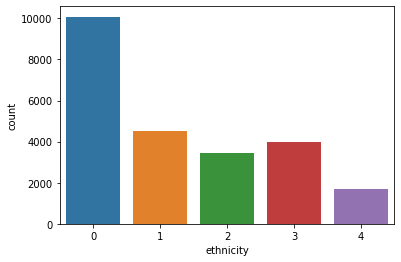

In [9]:
# Ethnicity distribution
sns.countplot(data=data, x='ethnicity');

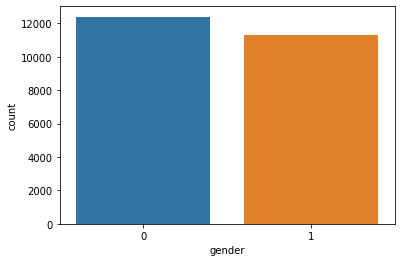

In [10]:
# Gender distribution
sns.countplot(data=data, x=data.gender);

## Split data

In [11]:
train, val = train_test_split(data, test_size=0.2, random_state=17)
val, test = train_test_split(val, test_size=0.4, random_state=17)

train.reset_index(inplace=True, drop=True)
val.reset_index(inplace=True, drop=True)
test.reset_index(inplace=True, drop=True)

print("Train data size:", train.shape[0])
print("Val data size:", val.shape[0])
print("Test data size:", test.shape[0])

Train data size: 18964
Val data size: 2844
Test data size: 1897


# Prepare custom data generator

In [12]:
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, dataframe, labels, batch_size, new_image_size=None, shuffle=False, augment=False):
        self.data = dataframe
        self.labels = labels
        self.new_image_size = new_image_size
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.augment = augment
        
        self.pixels = self.data.pixels.values
        self.indexes = np.arange(len(self.data))

    def __len__(self):
        return int(np.ceil(self.data.shape[0] / self.batch_size))

    def __getitem__(self, index):
        X = np.zeros((self.batch_size, *IMAGE_SIZE, 1))
        y = np.zeros((self.batch_size, len(self.labels)))

        interval = self.indexes[index * self.batch_size: (index+1)*self.batch_size]
        for i, sample_indx in enumerate(interval):
            X[i, :, :, :]  = self.pixels[sample_indx]
            y[i] = self.data.iloc[sample_indx][self.labels].values
        
        if self.new_image_size:
            X = tf.image.resize(X, self.new_image_size).numpy()
        if self.augment:
            X = self._augmentation(X).numpy()
        y = y.astype(int)
        y = [*y.T] if len(self.labels) > 1 else y.ravel()
        return X, y

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def _augmentation(self, img, rotation_range=np.pi/8):
        angle = np.random.uniform(low=-rotation_range, high=rotation_range)
        aug_image = tfa.image.rotate(img, angle, fill_mode='nearest')
        aug_image = tf.image.random_flip_left_right(img)
        return aug_image

In [13]:
def get_generators(labels, batch_size):
    train_gen = DataGenerator(train, labels=labels, batch_size=batch_size, shuffle=True, augment=True)
    val_gen = DataGenerator(val, labels=labels, batch_size=batch_size, shuffle=False, augment=False)
    test_gen = DataGenerator(test, labels=labels, batch_size=batch_size, shuffle=False, augment=False)
    
    return train_gen, val_gen, test_gen

# Gender model

In [14]:
def get_gender_model(input_shape):
    model = tf.keras.Sequential([
        Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same', input_shape=input_shape),
        MaxPooling2D((2, 2)),
        Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dense(1, activation='sigmoid'),
    ])
    return model

gender_model = get_gender_model((*IMAGE_SIZE, 1))
gender_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 12, 12, 64)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 9216)              0         
                                                                 
 dropout (Dropout)           (None, 9216)              0

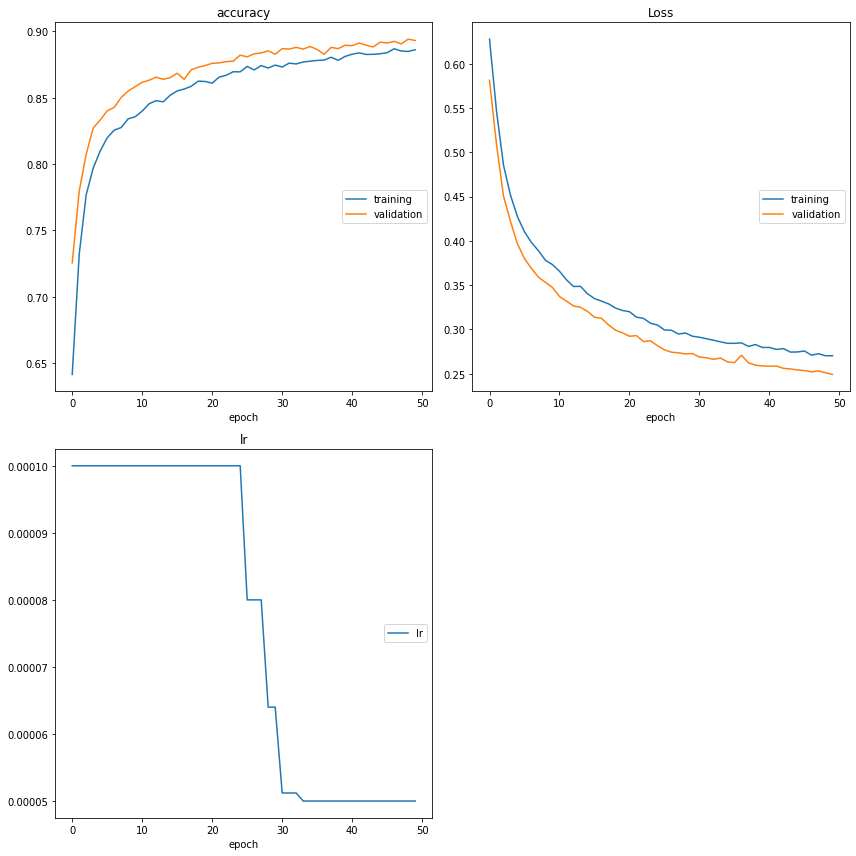

accuracy
	training         	 (min:    0.641, max:    0.887, cur:    0.886)
	validation       	 (min:    0.726, max:    0.894, cur:    0.893)
Loss
	training         	 (min:    0.270, max:    0.628, cur:    0.270)
	validation       	 (min:    0.249, max:    0.581, cur:    0.249)
lr
	lr               	 (min:    0.000, max:    0.000, cur:    0.000)
75/75 [==============================] - 14s 180ms/step - loss: 0.2703 - accuracy: 0.8862 - val_loss: 0.2492 - val_accuracy: 0.8932 - lr: 5.0000e-05


In [15]:
EPOCHS = 50
BATCH_SIZE = 256

train_gender_gen, val_gender_gen, test_gender_gen = get_generators(labels=['gender'],
                                                                   batch_size=BATCH_SIZE)

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
loss = tf.keras.losses.BinaryCrossentropy()

checkpoint = tf.keras.callbacks.ModelCheckpoint(CHECKPOINT_PATH + 'model_gender.h5',
                                                monitor='val_loss',
                                                mode='min',
                                                verbose=0,
                                                save_best_only=True,
                                                save_weights_only=False)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                 factor=0.8,
                                                 min_delta=0.005,
                                                 patience=2,
                                                 mode='min',
                                                 min_lr=5e-5)

callbacks = [checkpoint, reduce_lr, PlotLossesCallback()]

gender_model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])
gender_model.fit(train_gender_gen,
                 validation_data=[val_gender_gen],
                 epochs=EPOCHS,
                 callbacks=callbacks)

In [16]:
def draw_roc_auc_curve(test_labels, predictions):
    roc_auc = roc_auc_score(test_labels, predictions)
    fpr, tpr, _ = roc_curve(test_labels, predictions)
    plt.figure(figsize=(7, 7))
    plt.title('AUC-ROC Curve')
    plt.plot(fpr, tpr, label=f"auc {roc_auc}")
    plt.legend()
    plt.show()

In [17]:
def get_labels_and_predictions_from_generator(model, gen):
    labels, predicts = [], []
    for batch in gen:
        labels.append(batch[1])
        predicts.append(model.predict(batch[0], verbose=0))
                             
    return np.asarray(labels), np.asarray(predicts)

In [18]:
gender_model = tf.keras.models.load_model(CHECKPOINT_PATH + 'model_gender.h5')
loss, acc = gender_model.evaluate(test_gender_gen, verbose=0)
print('Test loss:', loss)
print('Test accuracy:', acc)

Test loss: 0.2369246482849121
Test accuracy: 0.9033203125


Recall score for gender classification: 0.8838862559241706
Precision score for gender classification: 0.8817966903073287
F-score for gender classification: 0.8828402366863904


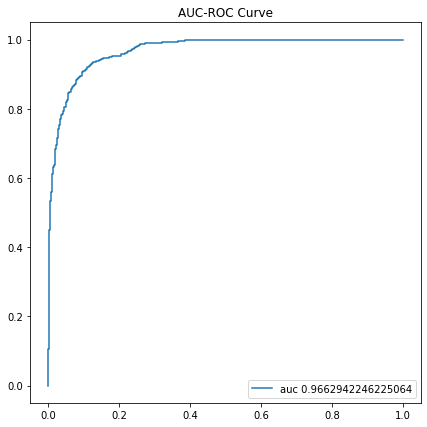

In [19]:
gender_true_labels, gender_predict_proba = \
    get_labels_and_predictions_from_generator(gender_model, test_gender_gen)

gender_true_labels, gender_predict_proba = \
    gender_true_labels.ravel(), gender_predict_proba.ravel()
gender_predict = (gender_predict_proba>0.5).astype(int)

precision = precision_score(gender_true_labels, gender_predict)
recall = recall_score(gender_true_labels, gender_predict)
f_score = f1_score(gender_true_labels, gender_predict)

print('Recall score for gender classification:', recall)
print('Precision score for gender classification:', precision)
print('F-score for gender classification:', f_score)
draw_roc_auc_curve(gender_true_labels, gender_predict_proba)

# Ethnicity model

In [22]:
def get_ethnicity_model(input_shape=(*IMAGE_SIZE, 1)):
    model = tf.keras.models.Sequential([
        Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same', input_shape=input_shape),
        MaxPooling2D((2, 2)),
        Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dropout(0.1),
        Dense(64, activation='relu'),
        Dense(5, activation='softmax')
    ])
    return model

ethnicity_model = get_ethnicity_model()
ethnicity_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 48, 48, 32)        320       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 24, 24, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 24, 24, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 12, 12, 64)       0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 9216)              0         
                                                                 
 dropout_2 (Dropout)         (None, 9216)             

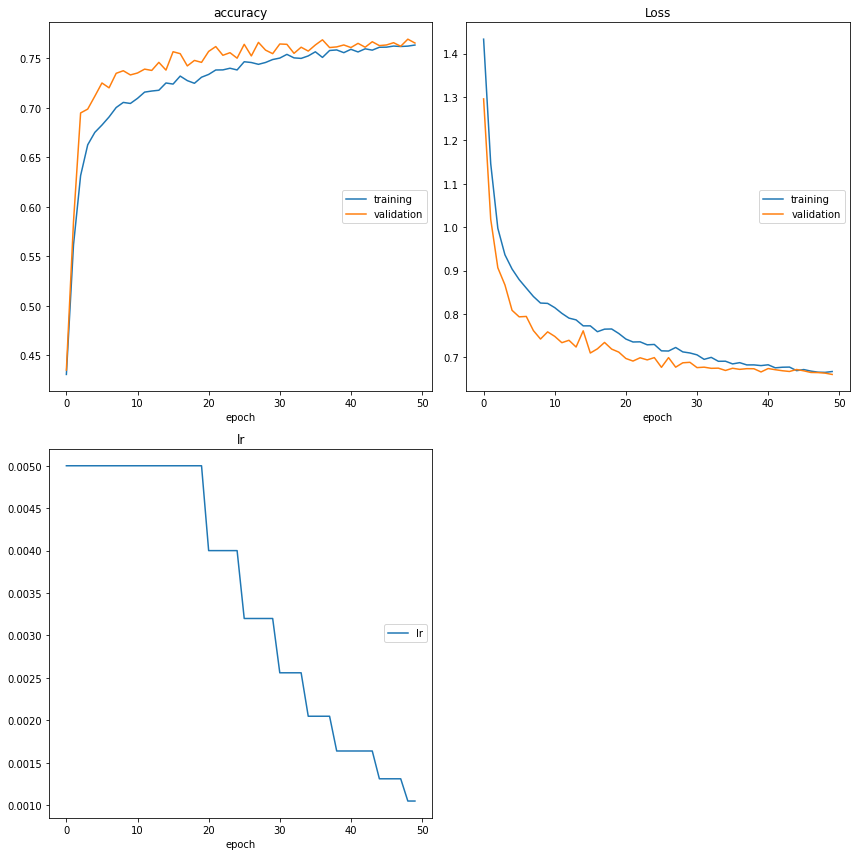

accuracy
	training         	 (min:    0.431, max:    0.764, cur:    0.764)
	validation       	 (min:    0.435, max:    0.770, cur:    0.766)
Loss
	training         	 (min:    0.665, max:    1.433, cur:    0.667)
	validation       	 (min:    0.660, max:    1.296, cur:    0.660)
lr
	lr               	 (min:    0.001, max:    0.005, cur:    0.001)
75/75 [==============================] - 14s 180ms/step - loss: 0.6672 - accuracy: 0.7636 - val_loss: 0.6605 - val_accuracy: 0.7656 - lr: 0.0010


In [23]:
EPOCHS = 50
BATCH_SIZE = 256

train_ethnicity_gen, val_ethnicity_gen, test_ethnicity_gen = \
    get_generators(labels=['ethnicity'], batch_size=BATCH_SIZE)

loss = tf.keras.losses.SparseCategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam(learning_rate=5e-3)

checkpoint = tf.keras.callbacks.ModelCheckpoint(CHECKPOINT_PATH + 'model_ethnicity.h5',
                                                monitor='val_loss',
                                                mode='min',
                                                verbose=0,
                                                save_best_only=True,
                                                save_weights_only=False)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                 factor=0.8,
                                                 min_delta=0.008,
                                                 patience=4,
                                                 mode='min',
                                                 min_lr=1e-4)

callbacks = [checkpoint, reduce_lr, PlotLossesCallback()]

ethnicity_model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])
ethnicity_model.fit(x=train_ethnicity_gen,
                    validation_data=[val_ethnicity_gen],
                    epochs=EPOCHS,
                    callbacks=callbacks)

In [24]:
ethnicity_model = tf.keras.models.load_model(CHECKPOINT_PATH + 'model_ethnicity.h5')
loss, acc = ethnicity_model.evaluate(test_ethnicity_gen, verbose=0)

ethnicity_true_lables, ethnicity_predict = \
    get_labels_and_predictions_from_generator(ethnicity_model, test_ethnicity_gen)

ethnicity_true_lables, ethnicity_predict = \
    ethnicity_true_lables.ravel(), ethnicity_predict.argmax(axis=2).ravel()

print('Test loss:', loss)
print('Test accuracy:', acc)
print(classification_report(ethnicity_true_lables, ethnicity_predict, digits=3))

Test loss: 0.6562022566795349
Test accuracy: 0.76611328125
              precision    recall  f1-score   support

           0      0.808     0.865     0.836       971
           1      0.754     0.807     0.780       368
           2      0.794     0.749     0.771       263
           3      0.656     0.707     0.681       321
           4      0.381     0.064     0.110       125

    accuracy                          0.766      2048
   macro avg      0.679     0.638     0.635      2048
weighted avg      0.747     0.766     0.749      2048



# Age model

In [25]:
def get_age_model(input_shape=(*IMAGE_SIZE, 1)):
    model = tf.keras.models.Sequential([
    Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same', input_shape=input_shape),
    MaxPooling2D((2, 2)),
    Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dense(1, activation='relu')])
    
    return model

age_model = get_age_model()
age_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 48, 48, 32)        320       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 24, 24, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 24, 24, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 12, 12, 64)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 12, 12, 128)       73856     
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 6, 6, 128)       

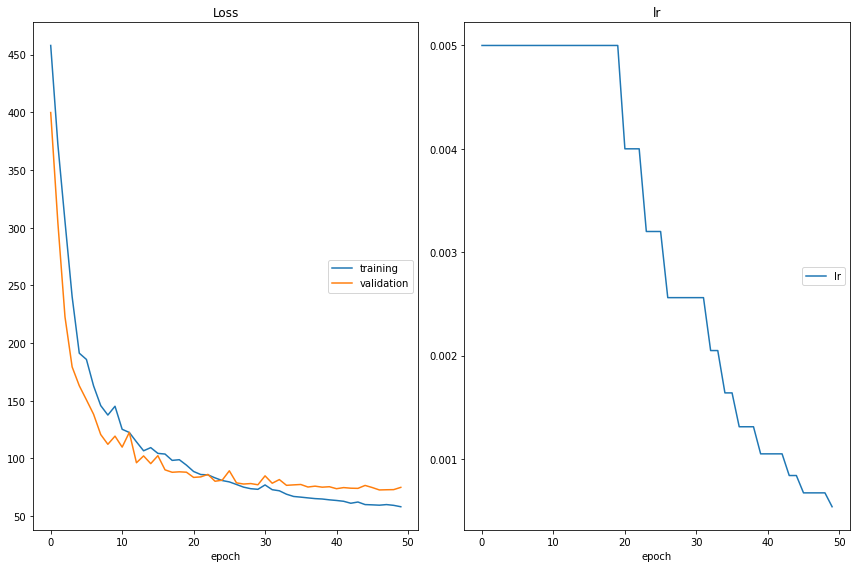

Loss
	training         	 (min:   58.153, max:  457.956, cur:   58.153)
	validation       	 (min:   72.704, max:  399.824, cur:   74.942)
lr
	lr               	 (min:    0.001, max:    0.005, cur:    0.001)
75/75 [==============================] - 14s 181ms/step - loss: 58.1534 - val_loss: 74.9421 - lr: 5.3687e-04


In [26]:
BATCH_SIZE = 256
EPOCHS = 50

train_age_gen, val_age_gen, test_age_gen = \
    get_generators(labels=['age'], batch_size=BATCH_SIZE)

loss = tf.keras.losses.MeanSquaredError()
optimizer = tf.keras.optimizers.Adam(learning_rate=5e-3)
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(CHECKPOINT_PATH + 'model_age.h5',
                                                               monitor='val_loss',
                                                               mode='min',
                                                               verbose=0,
                                                               save_best_only=True,
                                                               save_weights_only=False)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                 factor=0.8,
                                                 min_delta=0.5,
                                                 patience=2,
                                                 mode='min',
                                                 min_lr=5e-5)

callbacks = [model_checkpoint_callback, reduce_lr, PlotLossesCallback()]

age_model.compile(loss=loss, optimizer=optimizer)
age_model.fit(x=train_age_gen,
              epochs=EPOCHS,
              validation_data=[val_age_gen],
              callbacks=callbacks)

In [27]:
age_model = tf.keras.models.load_model(CHECKPOINT_PATH + 'model_age.h5')
loss = age_model.evaluate(test_age_gen, verbose=0)

age_true_labels, age_predict = \
    get_labels_and_predictions_from_generator(age_model, test_age_gen)

age_true_labels, age_predict = age_true_labels.ravel(), age_predict.ravel() 

mae = mean_absolute_error(age_true_labels, age_predict)
R2 = r2_score(age_true_labels, age_predict)

print('MSE:', loss)
print('MAE:', mae)
print('R^2 score:', R2)

MSE: 75.56717681884766
MAE: 6.090457223006524
R^2 score: 0.8362843479710859


## Show predictions

In [28]:
def plot_images(np_images, true_gender, true_ethnicity, true_age,
                pred_gender=None, pred_ethnicity=None, pred_age=None):
    plt.figure(figsize=(15, 15))
    for i in range(len(np_images)):
        if i > 15:
            break
        plt.subplot(4, 4, i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        pred_label = ''
        label = 'true ' + \
                f'gender:{int(true_gender[i])} '+ \
                f'ethnicity:{int(true_ethnicity[i])} ' + \
                f'age:{int(true_age[i])}'
        if pred_gender is not None and pred_ethnicity is not None and pred_age is not None:
            pred_label = 'predict ' + \
                         f'gender:{int(pred_gender[i])} '+ \
                         f'ethnicity:{int(pred_ethnicity[i])} ' + \
                         f'age:{int(pred_age[i])}'
        
        plt.xlabel(label+'\n'+pred_label)
        plt.imshow(np_images[i].reshape(IMAGE_SIZE), cmap='gray')

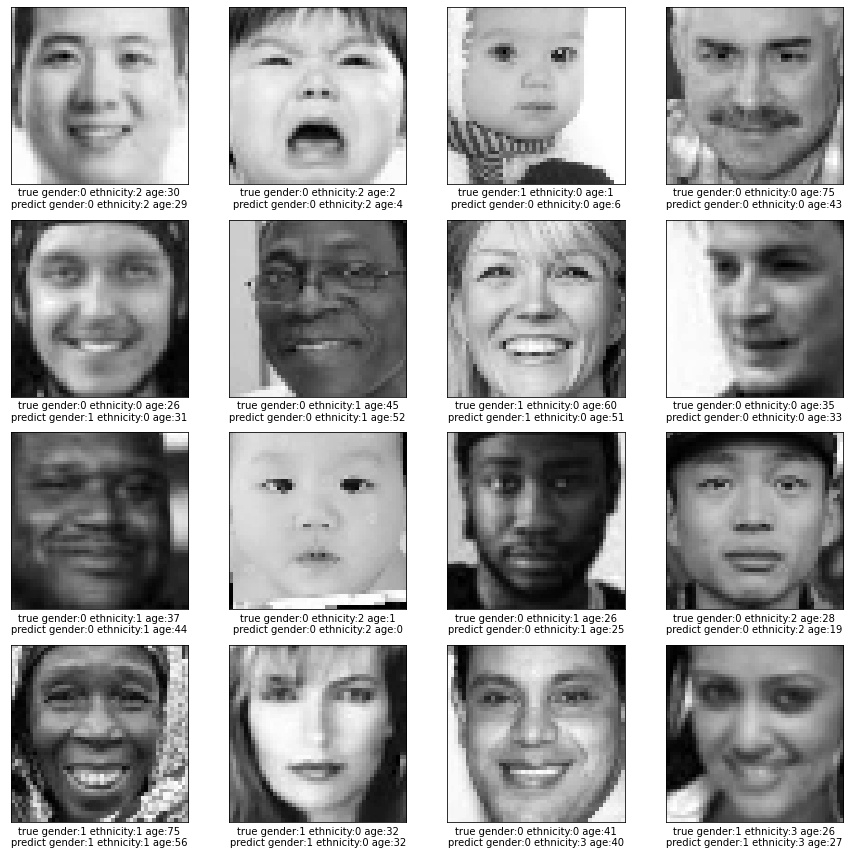

In [30]:
# show predictions of all models
rand_batch = np.random.choice(len(test_age_gen)-1)
images = test_age_gen[rand_batch][0]
cnt = images.shape[0]
start = rand_batch * cnt
end = start + cnt + 1
labels = [gender_true_labels, ethnicity_true_lables, age_true_labels]
predicts = [gender_predict, ethnicity_predict, age_predict]

plot_images(images, *[label[start: end] for label in labels],
            *[pred[start: end] for pred in predicts])

# Multitask learning

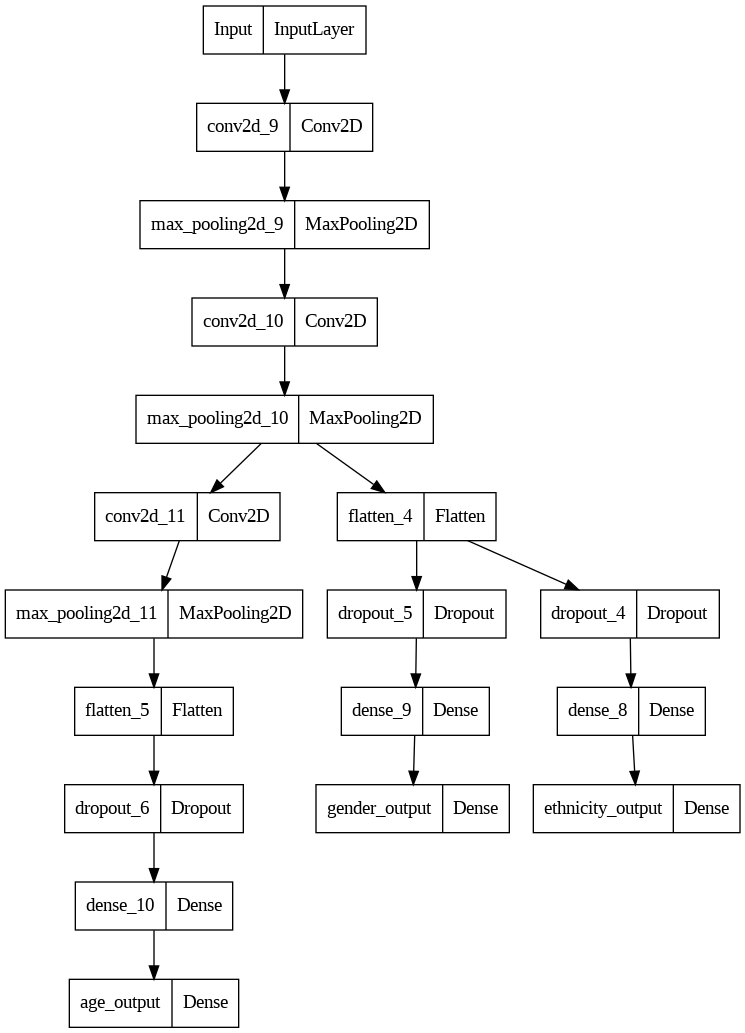

In [31]:
def get_multitask_model(input_shape=(*IMAGE_SIZE, 1)):
    input_layer = Input(shape=input_shape, name='Input')
    x = Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same')(input_layer)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)

    output_age = Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same')(x)

    x = Flatten()(x)

    output_ethnicity = Dropout(0.1)(x)
    output_ethnicity = Dense(64, activation='relu')(output_ethnicity)
    output_ethnicity = Dense(5, activation='softmax', name='ethnicity_output')(output_ethnicity)

    output_gender = Dropout(0.3)(x)
    output_gender = Dense(64, activation='relu')(output_gender)
    output_gender = Dense(1, activation='sigmoid', name='gender_output')(output_gender)

    output_age = MaxPooling2D((2, 2))(output_age)
    output_age = Flatten()(output_age)
    output_age = Dropout(0.3)(output_age)
    output_age = Dense(128, activation='relu')(output_age)
    output_age = Dense(1, activation='relu', name='age_output')(output_age)

    model = tf.keras.Model(inputs=input_layer, outputs=[output_gender, output_ethnicity, output_age])

    return model

model = get_multitask_model()
# model.summary()
plot_model(model)

In [32]:
EPOCHS = 60
BATCH_SIZE = 256

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

loss = {'gender_output': 'binary_crossentropy',
        'ethnicity_output': 'sparse_categorical_crossentropy',
        'age_output': 'mse'}

loss_weights={'gender_output': 1, 
              'ethnicity_output': 1.5, 
              'age_output': 0.002}

checkpoint = tf.keras.callbacks.ModelCheckpoint(CHECKPOINT_PATH + 'multitask_model.h5',
                                              monitore='val_loss',
                                              mode='min',
                                              verbose=0,
                                              save_best_only=True,
                                              save_weights_only=False)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                 factor=0.8,
                                                 min_delta=0.008,
                                                 patience=2,
                                                 mode='min',
                                                 min_lr=5e-5)

callbacks = [checkpoint, reduce_lr, PlotLossesCallback()]

model.compile(optimizer=optimizer, 
              loss=loss,
              loss_weights=loss_weights)


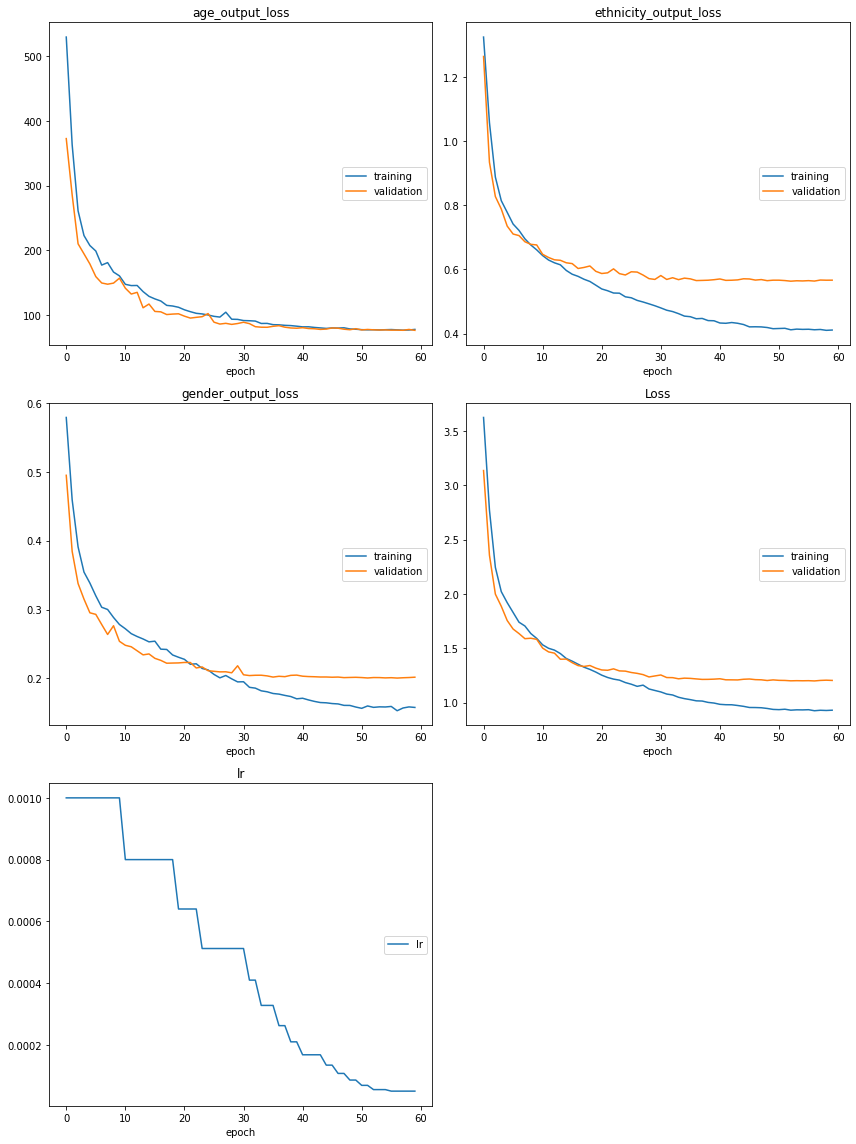

age_output_loss
	training         	 (min:   76.609, max:  529.799, cur:   77.813)
	validation       	 (min:   76.363, max:  372.814, cur:   76.363)
ethnicity_output_loss
	training         	 (min:    0.410, max:    1.324, cur:    0.411)
	validation       	 (min:    0.563, max:    1.264, cur:    0.566)
gender_output_loss
	training         	 (min:    0.153, max:    0.579, cur:    0.158)
	validation       	 (min:    0.201, max:    0.495, cur:    0.202)
Loss
	training         	 (min:    0.925, max:    3.625, cur:    0.930)
	validation       	 (min:    1.199, max:    3.136, cur:    1.204)
lr
	lr               	 (min:    0.000, max:    0.001, cur:    0.000)
75/75 [==============================] - 14s 185ms/step - loss: 0.9300 - gender_output_loss: 0.1579 - ethnicity_output_loss: 0.4110 - age_output_loss: 77.8131 - val_loss: 1.2042 - val_gender_output_loss: 0.2018 - val_ethnicity_output_loss: 0.5665 - val_age_output_loss: 76.3628 - lr: 5.0000e-05


In [33]:
train_gen, val_gen, test_gen = \
    get_generators(labels=['gender', 'ethnicity', 'age'], batch_size=BATCH_SIZE)

model.fit(train_gen,
          validation_data = val_gen,
          epochs=EPOCHS,
          verbose=1,
          callbacks=callbacks)

In [34]:
model = tf.keras.models.load_model(CHECKPOINT_PATH + 'multitask_model.h5')

In [35]:
_, gender_loss, ethnicity_loss, age_loss = \
    model.evaluate(test_gen, verbose=0)
print('Ethnicity loss:', ethnicity_loss)
print('Gender loss:', gender_loss)
print('Age loss (MSE):', age_loss)

Ethnicity loss: 0.5568103194236755
Gender loss: 0.20020920038223267
Age loss (MSE): 76.77297973632812


In [36]:
gender_pred_prob, ethnicity_pred, age_pred = np.array([]), np.array([]), np.array([])
gender_true, ethnicity_true, age_true = np.array([]), np.array([]), np.array([])
for batch in test_gen:
    gender_true = np.append(gender_true, batch[1][0]).astype(int)
    ethnicity_true = np.append(ethnicity_true, batch[1][1]).astype(int)
    age_true = np.append(age_true, batch[1][2]).astype(int)

    pred = model.predict(batch[0], verbose=0)
    gender_pred_prob = np.append(gender_pred_prob, pred[0].ravel())
    ethnicity_pred = np.append(ethnicity_pred, pred[1].argmax(axis=1).ravel()).astype(int)
    age_pred = np.append(age_pred, pred[2].ravel()).astype(int)
    
gender_pred = (gender_pred_prob>0.5).astype(int)

Precision score for gender: 0.8869463869463869
Recall score for gender: 0.9016587677725119
F-score for gender: 0.8942420681551116


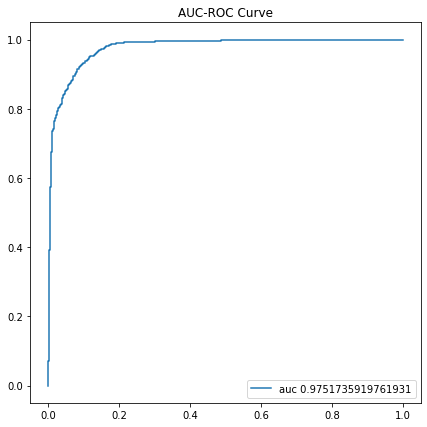

In [37]:
print('Precision score for gender:', precision_score(gender_true, gender_pred))
print('Recall score for gender:', recall_score(gender_true, gender_pred))
print('F-score for gender:', f1_score(gender_true, gender_pred))
draw_roc_auc_curve(gender_true, gender_pred_prob)

In [38]:
print(classification_report(ethnicity_true, ethnicity_predict, digits=3))

              precision    recall  f1-score   support

           0      0.808     0.865     0.836       971
           1      0.754     0.807     0.780       368
           2      0.794     0.749     0.771       263
           3      0.656     0.707     0.681       321
           4      0.381     0.064     0.110       125

    accuracy                          0.766      2048
   macro avg      0.679     0.638     0.635      2048
weighted avg      0.747     0.766     0.749      2048



In [39]:
print('Age MSE:', age_loss)
print('Age MAE:', mean_absolute_error(age_true, age_pred))
print('Age R^2 score:', r2_score(age_true, age_pred))

Age MSE: 76.77297973632812
Age MAE: 6.18896484375
Age R^2 score: 0.8322735750000421


Models individually show worse results on test data than the model with three outputs.

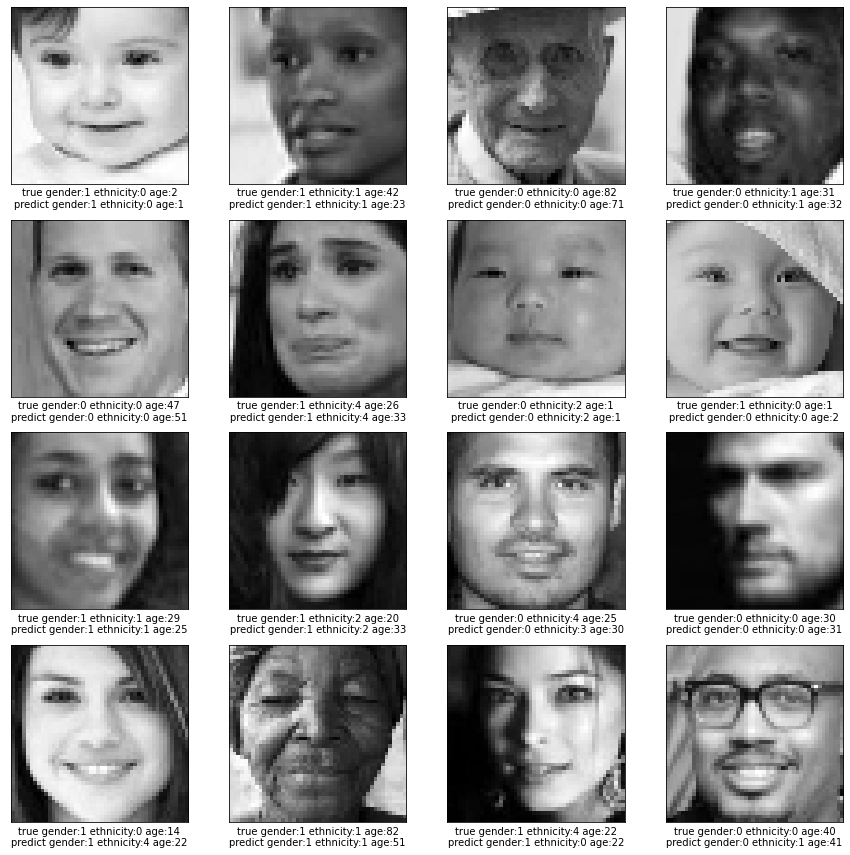

In [41]:
rand_batch = np.random.choice(len(test_age_gen)-1)
images = test_age_gen[rand_batch][0]
cnt = images.shape[0]
start = rand_batch * cnt
end = start + cnt + 1
labels = [gender_true, ethnicity_true, age_true]
predicts = [gender_pred, ethnicity_pred, age_pred]

plot_images(images, *[label[start: end] for label in labels],
            *[pred[start: end] for pred in predicts])